# scikit-learnの様々な分類アルゴリズムを試す
参考URL：[機械学習 iris データセットを用いて scikit-learn の様々な分類アルゴリズムを試してみた](https://qiita.com/ao_log/items/fe9bd42fd249c2a7ee7a)

# irisデータセットのロード

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

## データセットの説明
データセットの説明は DESCR (description) から見ることができます。

In [2]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

## データセットの形状
説明変数(特徴量)は 4 個で、150 個データがあります。形状は shape で確認できます。

In [3]:
iris.data.shape

(150, 4)

## 花の種類
目的変数は target_names に花の種類が格納されています。 3種類あります。

In [4]:
print(iris.target_names)

['setosa' 'versicolor' 'virginica']


# データを眺める

## データフレームに変換する
通常データ分析をする時はpandas.DataFrame(データフレーム)に変換します。<br>
pandas(データ解析ライブラリ）により、データが扱いやすくなります。<br>

In [5]:
import pandas as pd

df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target

target の行が 0, 1, 2 だと分かりにくいので種類名に置き換えます。<br>
今回は勉強会用にわかりやすさを重視して置き換えておきます。

In [6]:
df.loc[df['target'] == 0, 'target'] = "setosa"
df.loc[df['target'] == 1, 'target'] = "versicolor"
df.loc[df['target'] == 2, 'target'] = "virginica"

In [7]:
pd.concat([df.head(),df.tail()])

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


ざっくり眺めるには describe です。平均値、最小、最大値が分かります。

In [8]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


# ペアプロット
ペアプロットします。各特徴量のペアごとに散布図を表示させることができます。<br>

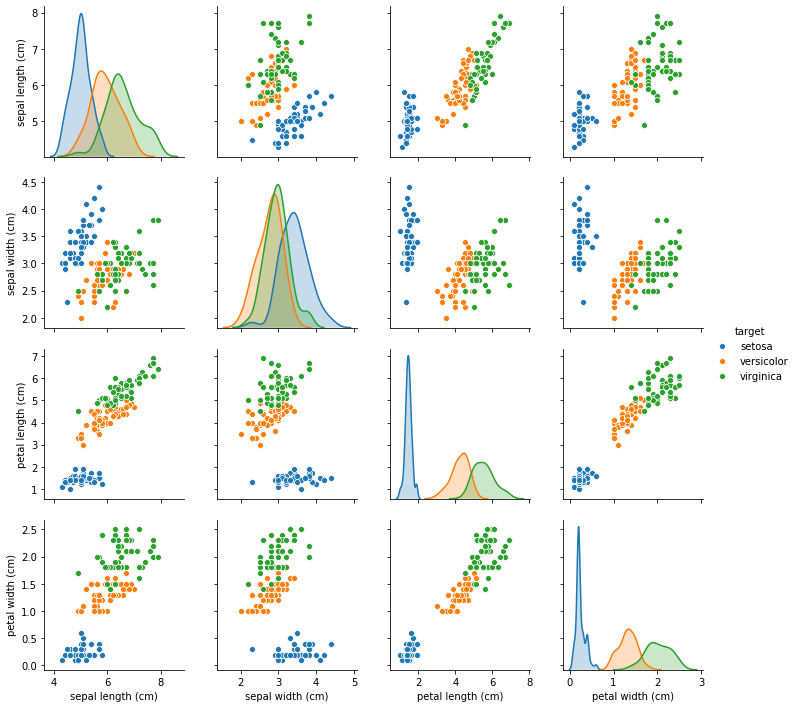

In [9]:
import seaborn as sns
# JupyterLab で実行する際は、この行を書くことで描画できるようになります。
%matplotlib inline

sns.pairplot(df, hue="target")

## 分類アルゴリズム

学習データの定義

In [10]:
# import some data to play with
X = iris.data[:, [0, 2]]   # sepal length, petal length (分類が簡単な組み合わせ。100%になってしまうこともある)
# X = iris.data[:, [0, 1]]   # sepal length, sepal width (分類が難しい組み合わせ。77%ほどしか精度が出ない)
y = iris.target

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from IPython.display import display

def decision_boundary(clf, X, y, ax, title, report_type="classification"):

    # graph common settings
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # データを訓練データとテストデータに分ける
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
    
    # 学習する
    clf.fit(X_train, y_train)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)

    # label
    ax.set_title(title)
    ax.set_xlabel('sepal length')
    ax.set_ylabel('petal length')
    
    # 学習データによる精度表示
    if report_type is "classification":
#         print('train classification_report')
        y_true = y_test
        y_pred = clf.predict(X_test)
        report_dict = classification_report(y_true, y_pred,
                                   target_names=["setosa","versicolor","virginica"],
                                   output_dict=True)
        df_report = pd.DataFrame(report_dict)
        display(df_report)
    elif report_type is "regression":
        print('Test score: {:.3f}'.format(clf.score(X_test, y_test)))    

# 教師あり学習
## k-近傍法　(k-NN)
モデルには訓練データセットを格納するだけです。予測時は、予測したいデータポイントの近くの k 個の近傍点を確認します。その中で一番多数派のクラスを予測結果として採用します。

KNeighborsClassifierを使用します。n_neighbors で予測に使用する近傍点の数を設定します。n_neighbors = 1 の場合は決定境界が鋭角になる部分もあります。数が多くなるに従いなだらかになっていき、10 になると境界が単純になりすぎて予測性能が落ちる場合があります。

,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,0.864865,0.800000,0.888889,0.888288,0.888168
precision,1.0,0.842105,0.833333,0.888889,0.891813,0.888694
recall,1.0,0.888889,0.769231,0.888889,0.886040,0.888889
support,14.0,18.000000,13.000000,0.888889,45.000000,45.000000


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,0.971429,0.962963,0.977778,0.978131,0.977872
precision,1.0,1.000000,0.928571,0.977778,0.976190,0.979365
recall,1.0,0.944444,1.000000,0.977778,0.981481,0.977778
support,14.0,18.000000,13.000000,0.977778,45.000000,45.000000


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,0.972973,0.960000,0.977778,0.977658,0.977634
precision,1.0,0.947368,1.000000,0.977778,0.982456,0.978947
recall,1.0,1.000000,0.923077,0.977778,0.974359,0.977778
support,14.0,18.000000,13.000000,0.977778,45.000000,45.000000


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,0.971429,0.962963,0.977778,0.978131,0.977872
precision,1.0,1.000000,0.928571,0.977778,0.976190,0.979365
recall,1.0,0.944444,1.000000,0.977778,0.981481,0.977778
support,14.0,18.000000,13.000000,0.977778,45.000000,45.000000


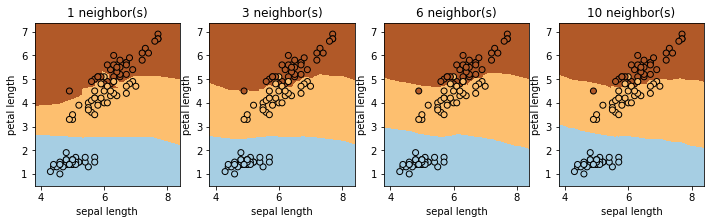

In [13]:
from sklearn.neighbors import KNeighborsClassifier

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for ax, n_neighbors in zip(axes, [1, 3, 6, 10]):
    title = "%s neighbor(s)"% (n_neighbors)
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    decision_boundary(clf, X, y, ax, title)

## ロジスティック回帰
名前に回帰とあリますが、分類アルゴリズムです。

LogisticRegressionを使用します。決定境界は直線になります。C は正則化の度合いを調整するパラメータです。正則化は学習時にペナルティを与えることで過学習を抑える効果があります。C を大きくすると正則化が弱くなり過学習気味になりますが、小さすぎるとデータの特徴を大雑把にしか獲得できません。

ロジスティック回帰などの線形モデルは高次元(特徴量の数が多い)のデータに対して有効です。理由は高速だから、他の手法では学習できないからです。

,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,0.965517,0.105263,0.619048,0.622222,0.563276,0.521324
precision,0.933333,1.000000,0.448276,0.622222,0.793870,0.819872
recall,1.000000,0.055556,1.000000,0.622222,0.685185,0.622222
support,14.000000,18.000000,13.000000,0.622222,45.000000,45.000000


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,0.971429,0.962963,0.977778,0.978131,0.977872
precision,1.0,1.000000,0.928571,0.977778,0.976190,0.979365
recall,1.0,0.944444,1.000000,0.977778,0.981481,0.977778
support,14.0,18.000000,13.000000,0.977778,45.000000,45.000000


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,1.0,1.0,1.0,1.0,1.0
precision,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0
support,14.0,18.0,13.0,1.0,45.0,45.0


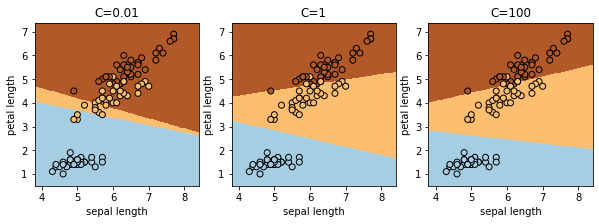

In [14]:
from sklearn.linear_model import LogisticRegression

fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for ax, C in zip(axes, [0.01, 1, 100]):
    title = "C=%s"% (C)
    clf = LogisticRegression(C=C, solver='lbfgs', multi_class='auto')
    decision_boundary(clf, X, y, ax, title)

C=L2正則化のコスト関数の重み係数<br>
C=100にすると精度が100%に達することがあるが、おそらくオーバーフィッティングしているのでよろしくない。

## 線形サポートベクタマシン
LinearSVCを使用します。線形なので、決定境界も直線になります。<br>
C はロジスティック回帰同様、正則化の度合いを調整するパラメータです。<br>
そのまま生データを使用すると精度が出ないため、StandardScaler()で標準化を行っています<br>
標準化を行うことでデータの平均は０に、分散は１になります。

/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,0.965517,0.0,0.604651,0.6,0.523389,0.475060
precision,0.933333,0.0,0.433333,0.6,0.455556,0.415556
recall,1.000000,0.0,1.000000,0.6,0.666667,0.600000
support,14.000000,18.0,13.000000,0.6,45.000000,45.000000


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,0.965517,0.758621,0.812500,0.844444,0.845546,0.838554
precision,0.933333,1.000000,0.684211,0.844444,0.872515,0.888031
recall,1.000000,0.611111,1.000000,0.844444,0.870370,0.844444
support,14.000000,18.000000,13.000000,0.844444,45.000000,45.000000


/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,0.971429,0.962963,0.977778,0.978131,0.977872
precision,1.0,1.000000,0.928571,0.977778,0.976190,0.979365
recall,1.0,0.944444,1.000000,0.977778,0.981481,0.977778
support,14.0,18.000000,13.000000,0.977778,45.000000,45.000000


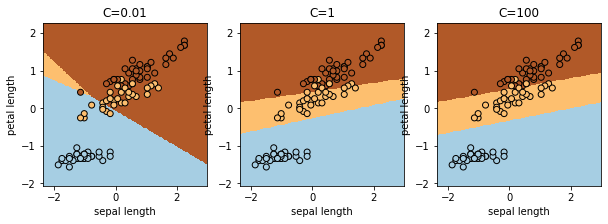

In [15]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_std = std.fit_transform(X)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for ax, C in zip(axes, [0.01, 1, 100]):
    title = "C=%s"% (C)
    clf = LinearSVC(C=C)
    decision_boundary(clf, X_std, y, ax, title)

## カーネル法を用いたサポートベクタマシン
SVM とも呼ばれます。線形カーネルベクタマシンと比べて、非線形な分離が可能です。<br>
<br>
SVCを使用します。C は正則化のパラメータです、gamma は訓練データの影響が及ぶ範囲で、小さいと遠くまで、大きいと近くになります。よって、gamma が大きすぎると過学習になり、小さすぎると大雑把にしかデータの特徴を獲得できません。<br>
<br>
パラメータの説明は RBF SVM parametersのページにも書かれています。<br>

/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,0.0,0.0,0.448276,0.288889,0.149425,0.129502
precision,0.0,0.0,0.288889,0.288889,0.096296,0.083457
recall,0.0,0.0,1.000000,0.288889,0.333333,0.288889
support,14.0,18.0,13.000000,0.288889,45.000000,45.000000


/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,0.0,0.0,0.448276,0.288889,0.149425,0.129502
precision,0.0,0.0,0.288889,0.288889,0.096296,0.083457
recall,0.0,0.0,1.000000,0.288889,0.333333,0.288889
support,14.0,18.0,13.000000,0.288889,45.000000,45.000000


/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,0.0,0.0,0.448276,0.288889,0.149425,0.129502
precision,0.0,0.0,0.288889,0.288889,0.096296,0.083457
recall,0.0,0.0,1.000000,0.288889,0.333333,0.288889
support,14.0,18.0,13.000000,0.288889,45.000000,45.000000


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,0.971429,0.962963,0.977778,0.978131,0.977872
precision,1.0,1.000000,0.928571,0.977778,0.976190,0.979365
recall,1.0,0.944444,1.000000,0.977778,0.981481,0.977778
support,14.0,18.000000,13.000000,0.977778,45.000000,45.000000


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,0.971429,0.962963,0.977778,0.978131,0.977872
precision,1.0,1.000000,0.928571,0.977778,0.976190,0.979365
recall,1.0,0.944444,1.000000,0.977778,0.981481,0.977778
support,14.0,18.000000,13.000000,0.977778,45.000000,45.000000


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,0.941176,0.928571,0.955556,0.956583,0.955836
precision,1.0,1.000000,0.866667,0.955556,0.955556,0.961481
recall,1.0,0.888889,1.000000,0.955556,0.962963,0.955556
support,14.0,18.000000,13.000000,0.955556,45.000000,45.000000


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,1.0,1.0,1.0,1.0,1.0
precision,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0
support,14.0,18.0,13.0,1.0,45.0,45.0


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,0.882353,0.857143,0.911111,0.913165,0.911671
precision,1.0,0.937500,0.800000,0.911111,0.912500,0.917222
recall,1.0,0.833333,0.923077,0.911111,0.918803,0.911111
support,14.0,18.000000,13.000000,0.911111,45.000000,45.000000


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,0.972973,0.960000,0.977778,0.977658,0.977634
precision,1.0,0.947368,1.000000,0.977778,0.982456,0.978947
recall,1.0,1.000000,0.923077,0.977778,0.974359,0.977778
support,14.0,18.000000,13.000000,0.977778,45.000000,45.000000


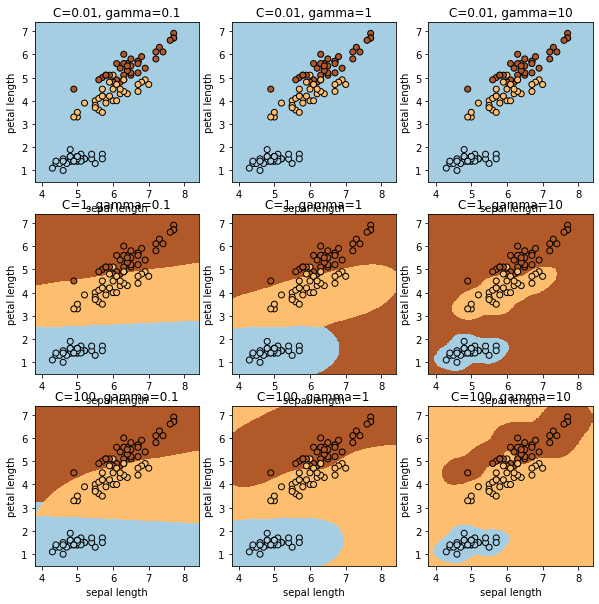

In [16]:
from sklearn.svm import SVC

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for ax_row, C in zip(axes, [0.01, 1, 100]):
    for ax, gamma in zip(ax_row, [0.1, 1, 10]):
        title = "C=%s, gamma=%s"% (C, gamma)
        clf = SVC(C=C, gamma=gamma)
        decision_boundary(clf, X, y, ax, title)

## 決定木
質問を通してデータを分類する手法です。あやめの場合は、花弁の長さが何センチ以上 or 未満、ガクの長さが何センチ以上 or 未満・・・と質問を繰り返すことで品種を特定していきます。

DecisionTreeRegressor を使用します。max_depth がツリーの深さで、質問数になります。多ければいいわけでもなく、訓練データに過剰適合するので過学習となります。

Test score: 0.705
Test score: 0.965
Test score: 0.926
Test score: 0.926


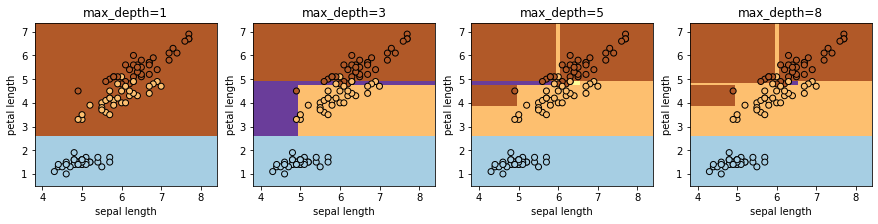

In [17]:
from sklearn.tree import DecisionTreeRegressor

fig, axes = plt.subplots(1, 4, figsize=(15, 3))

for ax, max_depth in zip(axes, [1, 3, 5, 8]):
    title = "max_depth=%s"% (max_depth)
    clf = DecisionTreeRegressor(max_depth=max_depth)
    decision_boundary(clf, X, y, ax, title, report_type="regression")

## ランダムフォレスト
ランダムフォレストは異なる決定木をたくさん作ります。<br>
全ての決定木で予測した結果からもっとも確率が高くなるラベルを正解とするものです。<br>
個々の木だと過剰適合しているかもしれないですが、多くの結果を集約することで過学習を抑制する効果があります。RandomForestClassifier を使います。<br>

,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,1.0,1.0,1.0,1.0,1.0
precision,1.0,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0,1.0
support,14.0,18.0,13.0,1.0,45.0,45.0


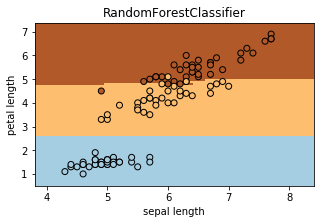

In [18]:
from sklearn.ensemble import RandomForestClassifier

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
clf = RandomForestClassifier(n_estimators=10)
decision_boundary(clf, X, y, ax, "RandomForestClassifier")

## 勾配ブースティング回帰木
勾配ブースティング回帰木(GBDT = Gradient Boosting Decision Tree)もたくさんの決定木を作るのですが、一つ前の決定木の予測値と正解のズレを修正するように次の木を作っていくのだそうです。GradientBoostingClassifier を使います。<br>
こちらの方がランダムフォレストよりモデル構築に時間がかかったり、パラメータ設定のチューニングが大変らしいのですが、その分予測性能がよくなるのだそうです。

,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,0.941176,0.928571,0.955556,0.956583,0.955836
precision,1.0,1.000000,0.866667,0.955556,0.955556,0.961481
recall,1.0,0.888889,1.000000,0.955556,0.962963,0.955556
support,14.0,18.000000,13.000000,0.955556,45.000000,45.000000


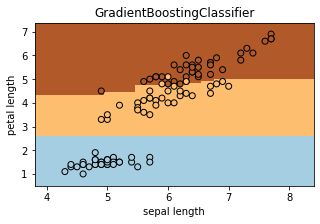

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
clf = GradientBoostingClassifier()
decision_boundary(clf, X, y, ax, "GradientBoostingClassifier")

## ニューラルネットワーク
scikit-learn にはニューラルネットワークのライブラリも実装されています。<br>
なお、scikit-learn は GPU に対応していない こともあり、ディープラーニングをやりたい場合は他のライブラリを選定した方がいいと思います。<br>

前置きはさておき、MLPClassifier を使います。<br>
隠れ層 15 個で計算した結果を図示しますが、同じパラメータでも決定境界が異なっています。<br>
そうなる理由は、それぞれ異なる初期状態から学習を開始しているためです。

/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,0.0,0.590909,0.6,0.530303,0.481818
precision,1.0,0.0,0.419355,0.6,0.473118,0.432258
recall,1.0,0.0,1.000000,0.6,0.666667,0.600000
support,14.0,18.0,13.000000,0.6,45.000000,45.000000


/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,0.838710,0.838710,0.888889,0.892473,0.888889
precision,1.0,1.000000,0.722222,0.888889,0.907407,0.919753
recall,1.0,0.722222,1.000000,0.888889,0.907407,0.888889
support,14.0,18.000000,13.000000,0.888889,45.000000,45.000000


/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,0.666667,0.742857,0.8,0.803175,0.792381
precision,1.0,1.000000,0.590909,0.8,0.863636,0.881818
recall,1.0,0.500000,1.000000,0.8,0.833333,0.800000
support,14.0,18.000000,13.000000,0.8,45.000000,45.000000


/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,setosa,versicolor,virginica,accuracy,macro avg,weighted avg
f1-score,1.0,0.0,0.590909,0.6,0.530303,0.481818
precision,1.0,0.0,0.419355,0.6,0.473118,0.432258
recall,1.0,0.0,1.000000,0.6,0.666667,0.600000
support,14.0,18.0,13.000000,0.6,45.000000,45.000000


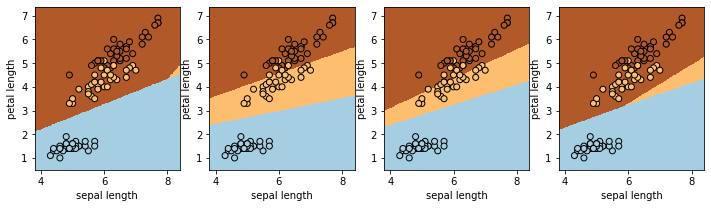

In [20]:
from sklearn.neural_network import MLPClassifier

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for ax, n in zip(axes, [15, 15, 15, 15]):
    title = ""
    clf = MLPClassifier(hidden_layer_sizes=[n, n])
    decision_boundary(clf, X, y, ax, title)

# 教師なし学習
## k-means
教師データなしで分類する手法です。KMeans を使います。n_clustersで何個に分類するかを指定します。

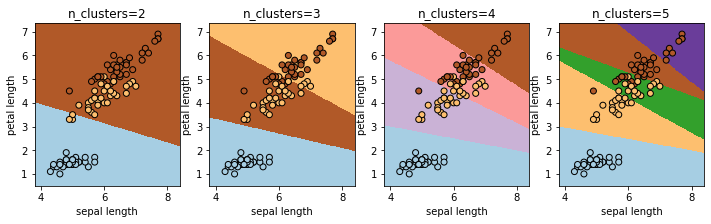

In [23]:
from sklearn.cluster import KMeans

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for ax, n_clusters in zip(axes, [2, 3, 4, 5]):
    title = "n_clusters=%s"% (n_clusters)
    clf = KMeans(n_clusters=n_clusters)
    decision_boundary(clf, X, y, ax, title, report_type=False)